In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

datas=pd.read_csv('Stock_history.csv')# The CSV file contains details of 5 stocks; BHEL,RELIANCE,ITC,INFOSYS and TCS
datas.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
12317,INFY,21-09-2020,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637
12318,INFY,22-09-2020,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762
12319,INFY,23-09-2020,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204
12320,INFY,24-09-2020,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432
12321,INFY,25-09-2020,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079


In [2]:
datas['Date'] = datas['Date'].astype('datetime64[ns]')
datas.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
12317,INFY,2020-09-21,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637
12318,INFY,2020-09-22,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762
12319,INFY,2020-09-23,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204
12320,INFY,2020-09-24,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432
12321,INFY,2020-09-25,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

# Feature construction
We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

Our dataset is built using raw data comprising of a 5-year price series for four different stocks. The individual stocks and index data consists of Date, Open, High, Low, Close and Volume. Using this data we calculated our indicators based on various technical indicators i.e. Exponential Moving Average, Stochastic Oscillator %K and %D, Relative Strength Index(RSI), Rate Of Change(ROC), Momentum (MOM)

In [5]:
# Initialize the `signals` DataFrame with the `signal` column
datas['signal'] = 0.0

# Create short simple moving average over the short window
datas['short_mavg'] = datas['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
datas['long_mavg'] = datas['Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
datas['signal'] = np.where(datas['short_mavg'] > datas['long_mavg'], 1.0, 0.0)

In [6]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datas['EMA21'] = EMA(datas, 21)
datas['EMA63'] = EMA(datas, 63)
datas['EMA252'] = EMA(datas, 252)
datas.tail()



,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,long_mavg,EMA21,EMA63,EMA252
12317,INFY,21-09-2020,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,795.850002,962.985119,903.096179,789.279139
12318,INFY,22-09-2020,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,799.023335,967.031927,906.358798,791.004205
12319,INFY,23-09-2020,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,802.175418,971.824479,909.902273,792.812472
12320,INFY,24-09-2020,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,805.280418,972.149528,911.949078,794.255852
12321,INFY,25-09-2020,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,808.787918,975.281387,914.906919,795.934462


In [7]:
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
datas['ROC21'] = ROC(datas['Close'], 21)
datas['ROC63'] = ROC(datas['Close'], 63)


In [8]:
#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
datas['MOM21'] = MOM(datas['Close'], 21)
datas['MOM63'] = MOM(datas['Close'], 63)


In [9]:
#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.rolling(period-1).mean() / \
         d.rolling(period-1).mean()
    return 100 - 100 / (1 + rs)
datas['RSI21'] = RSI(datas['Close'], 21)
datas['RSI63'] = RSI(datas['Close'], 63)
datas['RSI252'] = RSI(datas['Close'], 252)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD
datas['%K21'] = STOK(datas['Close'], datas['Low'], datas['High'], 21)
datas['%D21'] = STOD(datas['Close'], datas['Low'], datas['High'], 21)
datas['%K63'] = STOK(datas['Close'], datas['Low'], datas['High'], 63)
datas['%D63'] = STOD(datas['Close'], datas['Low'], datas['High'], 63)
datas['%K252'] = STOK(datas['Close'], datas['Low'], datas['High'], 252)
datas['%D252'] = STOD(datas['Close'], datas['Low'], datas['High'], 252)
datas.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,MOM63,RSI21,RSI63,RSI252,%K21,%D21,%K63,%D63,%K252,%D252
12317,INFY,21-09-2020,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,...,295.750000,63.706148,69.117661,52.909335,82.254019,85.253951,93.748155,94.984000,95.955922,96.772803
12318,INFY,22-09-2020,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,...,307.000000,65.694272,66.972127,52.815361,80.235496,81.726694,92.679128,93.557188,95.495927,95.922805
12319,INFY,23-09-2020,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,...,271.549988,65.624306,68.954864,53.022923,86.188954,82.892823,94.484412,93.637232,96.731407,96.061085
12320,INFY,24-09-2020,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,...,243.650024,55.425848,64.968443,52.435301,50.680573,72.368341,80.303765,89.155768,88.327811,93.518382
12321,INFY,25-09-2020,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,...,270.649964,62.711568,66.608232,53.158192,75.660514,70.843347,90.105769,88.297982,94.239692,93.099637


In [10]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
datas['MA21'] = MA(datas, 21)
datas['MA63'] = MA(datas, 63)
datas['MA252'] = MA(datas, 252)
datas.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
12317,INFY,21-09-2020,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,...,52.909335,82.254019,85.253951,93.748155,94.984000,95.955922,96.772803,952.550002,905.184923,762.235912
12318,INFY,22-09-2020,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,...,52.815361,80.235496,81.726694,92.679128,93.557188,95.495927,95.922805,955.411906,910.057939,762.949404
12319,INFY,23-09-2020,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,...,53.022923,86.188954,82.892823,94.484412,93.637232,96.731407,96.061085,959.300002,914.368256,763.697420
12320,INFY,24-09-2020,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,...,52.435301,50.680573,72.368341,80.303765,89.155768,88.327811,93.518382,960.471433,918.235717,764.275000
12321,INFY,25-09-2020,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,...,53.158192,75.660514,70.843347,90.105769,88.297982,94.239692,93.099637,963.307146,922.531748,765.012698


In [11]:
#Dealing with rows that contain NAN

datas.isnull().sum()
datasub=datas.dropna()
datasub.isnull().sum()
datasub.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
502,RELIANCE,01-10-2012,420.000000,421.149994,414.625000,416.750000,374.461090,3982938,1.0,403.820832,...,50.437264,60.427823,60.441532,72.506437,72.515961,69.174393,69.181576,407.645236,387.737697,385.166567
503,RELIANCE,03-10-2012,417.225006,426.725006,417.125000,423.049988,380.121765,10013278,1.0,404.351665,...,50.671821,70.267998,64.722556,79.708483,75.612084,74.606587,71.516850,409.622617,388.608729,385.263591
504,RELIANCE,04-10-2012,425.274994,429.450012,424.549988,426.450012,383.176819,5772464,1.0,405.103333,...,50.777746,75.595274,68.763698,83.595336,78.603418,77.538274,73.773085,411.367856,389.550396,385.353273
505,RELIANCE,05-10-2012,429.950012,431.000000,341.174988,428.899994,385.378235,7184276,1.0,406.158332,...,51.221567,88.055213,77.972828,88.055213,83.786344,79.650783,77.265215,413.430950,390.495634,385.451389
506,RELIANCE,08-10-2012,427.274994,427.274994,408.125000,409.700012,368.126465,9551586,1.0,406.780000,...,50.832579,68.782960,77.477816,68.782960,80.144503,63.095507,73.428188,414.649998,391.166666,385.513293


In [21]:
#excluding columns that are not needed for our prediction.

datasubs=datasub.drop(['Date','Symbol','Adj Close','Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
datasubs.head()

,signal,EMA21,EMA63,EMA252,ROC21,ROC63,MOM21,MOM63,RSI21,RSI63,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
502,1.0,410.571364,393.408361,391.232021,9.232686,13.193458,33.549988,48.049988,64.498870,58.821395,50.437264,60.427823,60.441532,72.506437,72.515961,69.174393,69.181576,407.645236,387.737697,385.166567
503,1.0,411.705784,394.334662,391.488239,8.530016,15.233228,41.524994,54.875000,63.912134,59.966138,50.671821,70.267998,64.722556,79.708483,75.612084,74.606587,71.516850,409.622617,388.608729,385.263591
504,1.0,413.046169,395.338266,391.769731,10.601050,15.459593,36.650024,59.325012,67.221396,60.133097,50.777746,75.595274,68.763698,83.595336,78.603418,77.538274,73.773085,411.367856,389.550396,385.353273
505,1.0,414.487426,396.387071,392.068639,11.663626,16.731308,43.324982,59.549988,68.721262,60.889205,51.221567,88.055213,77.972828,88.055213,83.786344,79.650783,77.265215,413.430950,390.495634,385.451389
506,1.0,414.052206,396.803100,392.210556,3.492267,11.970489,25.600006,42.275024,55.439705,57.301220,50.832579,68.782960,77.477816,68.782960,80.144503,63.095507,73.428188,414.649998,391.166666,385.513293


In [22]:
datas.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
0,RELIANCE,27-09-2010,504.000000,509.950012,502.549988,505.100006,435.443329,7527416,0.0,505.100006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RELIANCE,28-09-2010,504.149994,506.000000,496.500000,499.250000,430.400024,8998180,0.0,502.175003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RELIANCE,29-09-2010,500.000000,504.500000,497.500000,499.500000,430.615540,8133008,0.0,501.283335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RELIANCE,30-09-2010,501.000000,501.000000,489.049988,493.625000,425.550812,13249458,0.0,499.368751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RELIANCE,01-10-2010,496.000000,505.000000,495.000000,503.950012,434.451904,8733722,0.0,500.285004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Understanding the dataset using numbers and visuals
The most significant pre-requisite for predictive modeling is to have a good understanding of the dataset. The understanding helps in: Data transforms Choosing the right machine learning algorithms Explains the results obtained from the model Improves its accuracy We would like to see if we have a balanced data or not. And also visualize the correlation between the various features

upward  64.68697123519459% out of 11820 total datasize


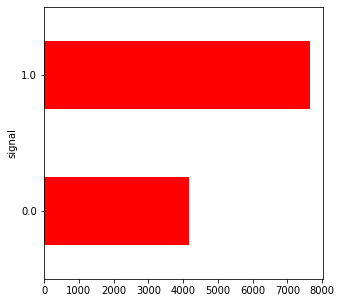

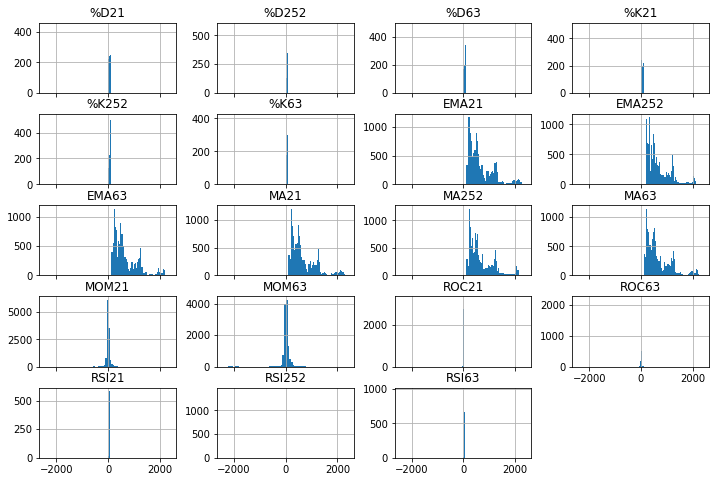

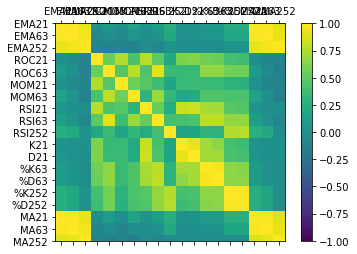

In [14]:
fig = plt.figure()
fig.set_size_inches(5,5)
data_s = datasubs.groupby(['signal']).size()
names=['EMA21','EMA63','EMA252','ROC21','ROC63','MOM21','MOM63','RSI21','RSI63','RSI252','K21','D21','%K63','%D63','%K252','%D252','MA21','MA63','MA252']

print("upward  {}% out of {} total datasize".format(100* data_s[1]/(data_s[1]+data_s[0]), data_s[1]+data_s[0]))
plot = data_s.plot(kind='barh', color='red')
X=datasubs.drop(['signal'], axis=1)
y=datasubs['signal']

# Plot the distributions of each input variable 
X.hist(bins=50, sharex=True, figsize=(12,8))

plt.show()


correlations = X.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

# Feature selection
Feature selection is the process of selecting a subset of features that are most relevant for model construction which aid in creating an accurate predictive model. There are a wide range of feature selection algorithms, and these mainly fall in one of the three categories:

Filter method– selects features by assigning a score to them using some statistical measure. Wrapper method– evaluates different subset of features, and determines the best subset. Embedded method – This method figures out which of the features give the best accuracy while the model is being trained.

In our model, we will use filter method utilising the random.forest.importance function. The random.forest.importance function rates the importance of each feature in the classification of the outcome, i.e. class variable. The function returns a data frame containing the name of each attribute and the importance value based on the mean decrease in accuracy.

In [15]:
forest = RandomForestClassifier(n_estimators=500,random_state=1,n_jobs=-1)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

        Importance
MA63      2.402532
EMA252    2.494578
EMA21     2.511547
MA21      2.553359
EMA63     2.613725
%K63      2.858358
MA252     2.939864
MOM21     3.056853
RSI21     3.215747
RSI252    3.578508
ROC21     3.601025
%D21      3.668962
%D63      3.771269
%K21      4.013667
%K252     7.972976
%D252     9.827961
MOM63    12.671832
RSI63    13.082054
ROC63    13.165183


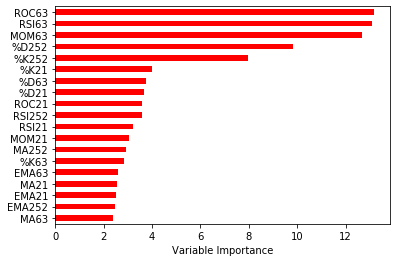

In [16]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm,neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Splitting
After creating models for unseen data, we will check their accuracy thanks to statistical methods. We evaluate the accuracy of the best model on actual unseen data to have the estimation more concrete. Meaning that we will use the algorithm on the training set and use the model on the test set afterwards for validation. We split the dataset into 80% training set and 20% test set.

In [24]:
X_1=datasub.drop(['signal'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)


(9456, 29) (9456,)
(2364, 29) (2364,)


# Modelling
In order to know which algorithm technique is the best for our strategy, we evaluate 5 non linear different methods:

1) K-Nearest Neighbors (KNN) 
2) Classification and Regression Trees (CART)
3) Support Vector Machines (SVM)
4) Random Forest (RF)
5) Gaussian Naïve Bayes (NB)
To ensure the comparatibility of the results (use the same data splits), the random number (seed = 1) is reset before each run.

In [29]:
from sklearn.preprocessing import RobustScaler
X_train_1=X_train.drop(['Close','Date','Symbol','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
X_test_1=X_test.drop(['Close','Symbol','Date','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)

In [30]:

# Spot Check Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))
data_Selected.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10, random_state=1)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.938981 (0.005140)
CART: 0.903869 (0.007155)


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

SVM: 0.904611 (0.009027)


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

RF: 0.943315 (0.005469)
NB: 0.784055 (0.011624)


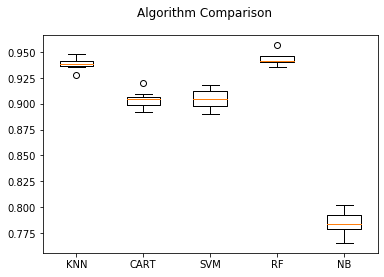

In [31]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [36]:

rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 10,n_jobs=4,criterion='gini')
predy=rf.fit(X_train_std, Y_train)

In [37]:
predr= rf.predict(X_test_std)

In [39]:
print(accuracy_score(Y_test, predr))
print(confusion_matrix(Y_test, predr))
print(classification_report(Y_test, predr))

0.9424703891708968
[[ 770   77]
 [  59 1458]]
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       847
         1.0       0.95      0.96      0.96      1517

    accuracy                           0.94      2364
   macro avg       0.94      0.94      0.94      2364
weighted avg       0.94      0.94      0.94      2364



In [40]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def pltcm(ax, y_test, y_pred, classes, title, th=0.7, cmap=plt.cm.Reds):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tickmarks = np.arange(len(classes))
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "yellow")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')

def pltauc(ax, y_train, y_pred, y_test, y_tpred, th=0.7):

    y_predl = (y_pred>th).astype(int)
    y_tpredl  = (y_tpred>th).astype(int)

    fpr_tr, tpr_tr, _ = roc_curve(y_train,y_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    acc_tr = accuracy_score(y_train, y_predl)

    fpr_ts, tpr_ts, _ = roc_curve(y_test,y_tpred)
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    acc_ts = accuracy_score(y_test, y_tpredl)

    ax.plot(fpr_tr, tpr_tr)
    ax.plot(fpr_ts, tpr_ts)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_tr, roc_auc_tr)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_ts, roc_auc_ts)
    ax.legend([train_text, test_text])

def result(es,threshold,X_train,X_test,y_train,y_test):
    y_pred = es.predict(X_train)
    y_tpred = es.predict(X_test)

    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    pltcm(ax[0],  y_train, y_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1],  y_test, y_tpred,   [0,1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_pred, y_test, y_tpred, threshold)
    plt.tight_layout()
    plt.show()
    
def btf1(es,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_tpred = es.predict(X_test)
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_tpred1  = (y_tpred > threshold).astype(int)
        score = f1_score(y_test, y_tpred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    return thresholds[index_threshold],sum_score/5

def testf1(es,bestthreshold,X_test,y_test):
    y_tpred = es.predict(X_test)
    y_tpred1  = (y_tpred > bestthreshold).astype(int)
    score = f1_score(y_test, y_tpred1)
    return score

test f1: 0.9554390563564875 train f1: 0.997717267242785


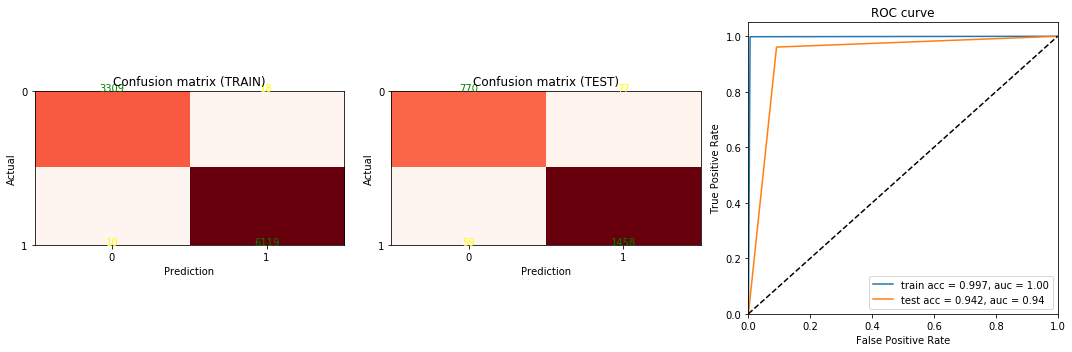

In [41]:
bestthreshold,bestf1 = btf1(rf,X_train_std, Y_train)
testf1 = testf1(rf,bestthreshold,X_test_std,Y_test)
print('test f1:',testf1,'train f1:',bestf1)
result(rf,bestthreshold,X_train_std,X_test_std, Y_train,Y_test)

,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
3761,1.0,0.0,NaN,NaN,NaN
10108,0.0,0.0,-0.427096,-0.000000,-0.427096
6709,1.0,1.0,3.256091,0.000000,0.000000
3856,1.0,1.0,-0.566542,-0.566542,-0.566542
3950,1.0,1.0,0.131879,0.131879,0.131879


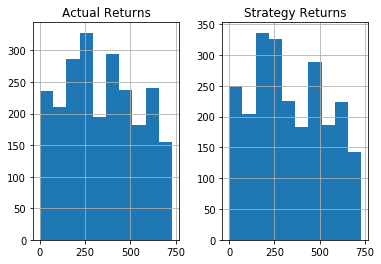

In [62]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predr
backtestdata['signal_actual'] = Y_test
backtestdata['Market Returns'] = X_test['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata.head()

# Conclusion
Based on the model predictions, the accuracy of the model is reported to be around the 94% mark. The momentum trading strategy 
predicted the stock prices at which we can invest/deinvest in order to make profits. This model helps us make fewer losses
compared to the actual returns.